# Data Preprocessing

In [1]:
import pandas as pd
import PIL
from glob import glob
import os
import re
import random
import chitra
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from chitra.image import Chitra
from sklearn.model_selection import train_test_split

In [40]:

def load_data(typ):

    """Load image data and join with annotation information."""

    df_annotation = pd.read_csv(f"data/roboflow_data/{typ}/_annotations.csv")
    df_img = pd.DataFrame()

    base_dir = rf'data/roboflow_data/{typ}/*.jpg'
    
    files = glob(base_dir)

    imgs = []
    for i in files:
        imgs.append(plt.imread(i))

    files = [re.sub(f'data/roboflow_data/{typ}/', '', i) for i in files]

    df_img['filename'] = files
    df_img['image'] = imgs
    df_train = pd.merge(df_annotation, df_img, on='filename')
    return df_train


In [41]:
df_train = load_data('train')
df_valid = load_data('valid')
df_test = load_data('test')

df_total = pd.concat([df_train, df_valid, df_test])

print(df_total.info())
#print(df_valid.info())
#print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64175 entries, 0 to 1184
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  64175 non-null  object
 1   width     64175 non-null  int64 
 2   height    64175 non-null  int64 
 3   class     64175 non-null  object
 4   xmin      64175 non-null  int64 
 5   ymin      64175 non-null  int64 
 6   xmax      64175 non-null  int64 
 7   ymax      64175 non-null  int64 
 8   image     64175 non-null  object
dtypes: int64(6), object(3)
memory usage: 4.9+ MB
None


In [42]:
# write data to pickle:
#df_total.to_pickle('data/df_total.pickle')

In [2]:
df_total = pd.read_pickle('data/df_total.pickle')

In [3]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64175 entries, 0 to 1184
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  64175 non-null  object
 1   width     64175 non-null  int64 
 2   height    64175 non-null  int64 
 3   class     64175 non-null  object
 4   xmin      64175 non-null  int64 
 5   ymin      64175 non-null  int64 
 6   xmax      64175 non-null  int64 
 7   ymax      64175 non-null  int64 
 8   image     64175 non-null  object
dtypes: int64(6), object(3)
memory usage: 4.9+ MB


In [45]:
# check ranges of bounding boxes
#df_train[['xmin', 'ymin', 'xmax', 'ymax']].agg(['max', 'min'])

In [46]:
# Display sample image with annotation

sample_img = df_train.iloc[1111,:] #4801


figsize = sample_img['width'] / float(100), sample_img['height']/ float(100)
fig, ax = plt.subplots(figsize=figsize)
#new_width = sample_img['width'] / 6.4
#new_height = sample_img['height'] / 4.8

#ax.axis('off')
ax.imshow(sample_img['image'])
rect = patches.Rectangle((sample_img['xmin'], sample_img['ymin']), 
                         sample_img['xmax']-sample_img['xmin'], 
                         sample_img['ymax']-sample_img['ymin'],
                         edgecolor='red',
                         facecolor='none',
                         linewidth=3,
                         )

ax.add_patch(rect)
annot_height = sample_img['ymin'] + (sample_img['ymax']-sample_img['ymin']) + 20
ax.annotate(sample_img['class'], (sample_img['xmin'], annot_height), color='red',
            size=20)

Text(379, 474, 'black-knight')

Some annotations are incorrect (e.g. axes transposed). Manually check if annotations are correct in `check_annotations.ipynb`.

## Load checked data

In [4]:
# Add togehther annotations
annot_1 = pd.read_csv('data/checked_annot/top_184_anot.csv')
annot_2 = pd.read_csv('data/checked_annot/bottom_annot.csv')
annot_3 = pd.read_csv('data/checked_annot/bottom_annot_1602_downwards.csv')
annot_4 = pd.read_csv('data/checked_annot/test_annot.csv')
annot_5 = pd.read_csv('data/checked_annot/valid_annot.csv')

In [5]:
# Concatenate sheets
annot_total = pd.concat([annot_1, annot_2, annot_3, annot_4, annot_5])
#annot_total = pd.concat([annot_4, annot_5])
annot_total.info()
print('*'*60)
annot_total.groupby('correct_anot').count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1718 entries, 0 to 605
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1718 non-null   int64 
 1   filename      1718 non-null   object
 2   correct_anot  1707 non-null   object
dtypes: int64(1), object(2)
memory usage: 53.7+ KB
************************************************************


,Unnamed: 0,filename
correct_anot,,
n,235,235
y,1472,1472


In [6]:
# Filter for correctly annotated
annot_correct = annot_total[annot_total['correct_anot'] == 'y']

# get length of correctly annotated:
annot_img_list = list(annot_correct['filename'].unique())
print(len(annot_img_list))

1384


In [7]:
# get new dataset
chess_df = df_total[df_total['filename'].isin(annot_img_list)]
#print(chess_df.info())

# Check unique pictures
chess_df['filename'].nunique()

1384

In [8]:
# Write data to csv
#chess_df.to_pickle('data/chess_new.p')

## Resizing images

Given that `image` is a `Chitra` object:

* Get ndarray of image with `image.numpy()`
* Get resized bounding box xmin, ymin with `image.bboxes[0][0]`
* Get resized bounding box xmax, ymax with `image.bboxes[0][1]`
* Get resized bounding box label with `image.bboxes[0].label`

In [4]:
# laod data:
chess_df = pd.read_pickle('data/chess_new.p')

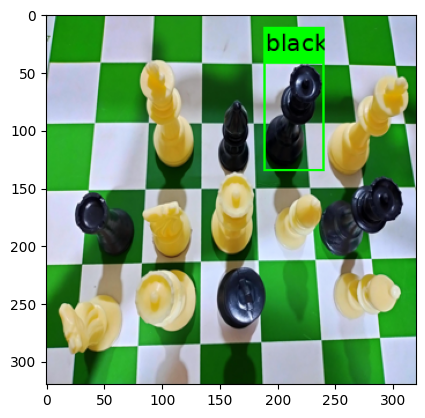

In [18]:
# display sample image with chitra

import chitra
from chitra.image import Chitra

tryout = chess_df.iloc[4]

ymin = tryout['ymin']
ymax = tryout['ymax']
xmin = tryout['xmin']
xmax = tryout['xmax']

label = tryout['class']

bbox = [xmin, ymin, xmax, ymax]

filename = tryout['filename']

img_path = f'data/roboflow_data/train/{filename}'
image = Chitra(img_path, bboxes=bbox, labels=label, box_format= 'BoundingBoxes.CORNER')
image.resize_image_with_bbox((320, 320))

figsize = tryout['width'] / float(100), tryout['height']/ float(100)

#plt.figure(figsize=figsize)
plt.imshow(image.draw_boxes())

In [7]:
def resize_images(samp, resize = (320, 320)):
    
    """Convert one row of chess df to dictionary with resized information."""

    bbox = [samp['xmin'], samp['ymin'], samp['xmax'], samp['ymax']]
    
    filename = samp['filename']
    img_path = f'data/roboflow_data/total/{filename}'
    
    image = Chitra(img_path, bboxes=bbox, labels=samp['class'], box_format='BoundingBoxes.CORNER')
    image.resize_image_with_bbox(resize)

    return {'filename': filename, 
            'width': image.shape[0], 
            'height': image.shape[1], 
            'class': image.bboxes[0].label, 
            'xmin': image.bboxes[0][0][0], 
            'ymin': image.bboxes[0][0][1], 
            'xmax' : image.bboxes[0][1][0], 
            'ymax': image.bboxes[0][1][1], 
            'image': image.numpy()}

In [8]:
# Iterate through dataset and append resized images
df_chess_resized= pd.DataFrame()

for i in range(chess_df.shape[0]):
    
    df_add = pd.DataFrame.from_dict(resize_images(chess_df.iloc[i]), orient='index').T
    df_chess_resized = pd.concat([df_chess_resized, df_add], axis=0, ignore_index=True)

In [9]:
# Check classes
df_chess_resized['class'].unique()

array(['black-bishop', 'black-king', 'black-queen', 'black-rook',
       'white-bishop', 'white-knight', 'white-king', 'white-queen',
       'black-knight', 'black-pawn', 'pawn_white', 'white-rook',
       'white-pawn', 'rook_black', 'knight_white', 'knight_black',
       'rook_white', 'queen_black', 'pawn_black'], dtype=object)

In [10]:
def clean_classes(class_name):
    """
    Changes the words of the class name if '_' is included in class name.
    Example: 'pawn_black' -> 'black-pawn'
    """
    if '_' in class_name:

        class_name_split = class_name.split('_')
        new_class_name = f"{class_name_split[1]}-{class_name_split[0]}"
        return new_class_name
    
    else:
        return class_name

In [11]:
# Replace "_" with "-" to get the needed 12 classes
df_chess_resized['class'] = df_chess_resized['class'].apply(lambda x: clean_classes(x))

In [12]:
# Check classes again
df_chess_resized['class'].unique(), len(df_chess_resized['class'].unique())

(array(['black-bishop', 'black-king', 'black-queen', 'black-rook',
        'white-bishop', 'white-knight', 'white-king', 'white-queen',
        'black-knight', 'black-pawn', 'white-pawn', 'white-rook'],
       dtype=object),
 12)

In [13]:
#df_chess_resized.to_pickle('data/chess_resized.p')

## Data split

In [14]:
# load data
chess_resized_df = pd.read_pickle('data/chess_resized.p')

In [15]:
# get all filenames
list_filenames = chess_resized_df['filename'].unique()
#print(len(list_filenames))

# 0.8, 0.1, 0.1 train, val, test split 
#train_files, rest_files = train_test_split(list_filenames, train_size=0.8, random_state=37, shuffle=True)
#val_files, test_files = train_test_split(rest_files, train_size=0.5, random_state = 41, shuffle=True)


# 0.8 0.2 train test split
train_files, test_files = train_test_split(list_filenames, train_size=0.8, random_state=37, shuffle=True)


print(f'train file length: {len(train_files)}\ntest file length: {len(test_files)}')

train file length: 1107
test file length: 277


In [16]:
# filter new dfs based on filename split 
chess_train_df = chess_resized_df[chess_resized_df['filename'].isin(train_files)]
#chess_val_df = chess_resized_df[chess_resized_df['filename'].isin(val_files)]
chess_test_df = chess_resized_df[chess_resized_df['filename'].isin(test_files)]

# check if percentage is still correct since not all chess images have the same amount of bounding boxes (rows)
# print(f'train length: {len(chess_train_df)}, percent: {round(len(chess_train_df)/chess_resized_df.shape[0], 2)}\n\
# valid length: {len(chess_val_df)}, percent: {round(len(chess_val_df)/chess_resized_df.shape[0], 2)}\n\
# test length: {len(chess_test_df)}, percent: {round(len(chess_test_df)/chess_resized_df.shape[0], 2)}')

print(f'train length: {len(chess_train_df)}, percent: {round(len(chess_train_df)/chess_resized_df.shape[0], 2)}\n\
test length: {len(chess_test_df)}, percent: {round(len(chess_test_df)/chess_resized_df.shape[0], 2)}')


train length: 18028, percent: 0.8
test length: 4495, percent: 0.2


In [17]:
# write files
#chess_train_df.to_pickle('data/final_data/train/chess_train_df.p')
#chess_val_df.to_pickle('data/final_data/val/chess_val_df.p')
#chess_test_df.to_pickle('data/final_data/test/chess_test_df.p')

In [16]:
chess_train_df = pd.read_pickle('data/final_data/chess_train_df.p')
chess_test_df = pd.read_pickle('data/final_data/chess_test_df.p')

chess_train_plt_df = chess_train_df
chess_test_plt_df = chess_test_df


chess_train_plt_df['dataset'] = 'train'
chess_test_plt_df['dataset'] = 'test'
chess_plt_df = pd.concat([chess_train_plt_df, chess_test_plt_df])

In [17]:
# chesspiece class distribution
fig = px.histogram(chess_plt_df, x="class", color='dataset', template='plotly_white')
fig.show()


In [19]:
print(f'train length: {len(chess_train_df)}, test length: {len(chess_test_df)}')

train length: 18028, test length: 4495


## Save new arrays as images

In [18]:
from PIL import Image

def export_images(df_split, split_type):

    for i in range(df_split.shape[0]):
        im = Image.fromarray(df_split.iloc[i]['image'])
        filename = df_split.iloc[i]['filename']
        im.save(f'data/final_data/{split_type}/{filename}.jpeg')


In [19]:
export_images(chess_train_df, 'train')
#export_images(chess_val_df, 'val')
export_images(chess_test_df, 'test')


In [21]:
chess_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18028 entries, 13 to 22522
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  18028 non-null  object
 1   width     18028 non-null  object
 2   height    18028 non-null  object
 3   class     18028 non-null  object
 4   xmin      18028 non-null  object
 5   ymin      18028 non-null  object
 6   xmax      18028 non-null  object
 7   ymax      18028 non-null  object
 8   image     18028 non-null  object
dtypes: object(9)
memory usage: 1.4+ MB


In [20]:
# export as csv

#chess_train_df.to_csv('data/final_data/train_df.csv')
#chess_test_df.to_csv('data/final_data/test_df.csv')


In [33]:
# create directory structure for dataloader:

# import os 

# labels = chess_resized_df['class'].unique().tolist()

# for d in ['train', 'val', 'test']:
#     os.mkdir(f'data/final_data/{d}/{d}_flow')
#     for c in labels:
#         os.mkdir(f'data/final_data/{d}/{d}_flow/{c}')



In [39]:
# export images to their respective folder in directory:
# from PIL import Image

# def export_images_to_class(df_split, split_type):

#     for i in range(df_split.shape[0]):
        
#         im = Image.fromarray(df_split.iloc[i]['image'])
        
#         filename = df_split.iloc[i]['filename']
#         piece_type = df_split.iloc[i]['class']

#         im.save(f'data/final_data/{split_type}/{split_type}_flow/{piece_type}/{filename}.jpeg')


In [40]:
# export_images_to_class(chess_train_df, 'train')
# export_images_to_class(chess_val_df, 'val')
# export_images_to_class(chess_test_df, 'test')


## Prepare sample data for Tensorflow lite object detector

In [66]:
# take small sample to tryout
chess_train_sample_df = pd.read_pickle('data/final_data/train/chess_train_df.p')#.iloc[:500]
chess_val_sample_df = pd.read_pickle('data/final_data/val/chess_val_df.p')#.iloc[:100]
chess_test_sample_df = pd.read_pickle('data/final_data/test/chess_test_df.p')#.iloc[:100]


In [67]:

def create_tfl_data(df, datatyp):

    """
    Transform data for model tf lite dataloader.
    """
    # add variables
    df['datatype'] = f'{datatyp}'
    df['file_location'] = df['filename'].apply(lambda x: f'/content/drive/MyDrive/Chesspiece_detection/data/images/{x}.jpeg')

    # rescale bounding box positions:
    df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']]/224

    # get the exact same datastructure
    tfl_df = df[['datatype', 'file_location', 'class', 'xmin', 'ymin']]
    tfl_df['empty1'] = ''
    tfl_df['empty2'] = ''
    tfl_df[['xmax', 'ymax']] = df[['xmax', 'ymax']]

    return tfl_df


In [ ]:
tfl_train_df = create_tfl_data(chess_train_sample_df, 'TRAIN')
tfl_val_df = create_tfl_data(chess_val_sample_df, 'VALIDATE')
tfl_test_df = create_tfl_data(chess_test_sample_df, 'TEST')

In [69]:
tfl_data = pd.concat([tfl_test_df, tfl_val_df, tfl_train_df])

In [70]:
# save data
#tfl_data.to_csv('data/tfl_data.csv', header=False, index=False)